# Import packages and read cleansed data

In [1]:
import sklearn
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', 500)
import xgboost
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import pykrige
import numpy as np
import catboost as cb
import os

In [2]:
cleaned_data_input_path  ="../../data/clean_survey_data/2019_clean_soil_weather.csv"

In [3]:
df_raw = pd.read_csv(cleaned_data_input_path, low_memory=False)
df=df_raw.copy()

In [4]:
# Define whether to look at soy or groundnut data
target_crop = "gr"

if target_crop== "so":
    full_target_crop_name = "soybeans"
    non_target_crop="gr"
elif target_crop== "gr":
    full_target_crop_name = "groundnuts"
    non_target_crop="so"

crop_mask = (df[full_target_crop_name] == 1)
target_variable= f"{target_crop}_land_prod"

# Reduce dataframe only to focus crop of interest. 
df = df.loc[crop_mask, :].reset_index(drop=True)

# Create and inspect variogram over different soil properties

soc_15-30cm_mean.tif
ocd_0-5cm_mean.tif
bdod_15-30cm_mean.tif


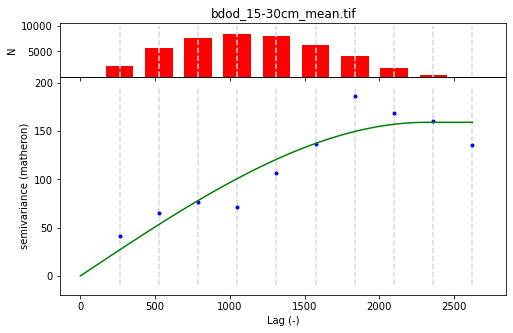

In [5]:
import rasterio
from skgstat import Variogram
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
soildata_filenames = os.listdir("../../data/soildata/")
soildata_filenames.remove(".gitignore")
if ".DS_Store" in soildata_filenames:
    soildata_filenames.remove(".DS_Store")

#Loop over all downloaded files and open them only once
for filename in soildata_filenames[0:3]:
    print(filename)
    with rasterio.open(f"../../data/soildata/{filename}", driver="GTiff") as variable:
        variable_numpygrid = variable.read(1)
        coords = np.random.randint(low=(0,0), high=variable_numpygrid.shape, size=(300, 2))
        values = np.fromiter((variable_numpygrid[c[0], c[1]] for c in coords), dtype=float)
        V = Variogram(coords, values)
        V.plot()
        plt.title(filename)


# Plots of productivity

Text(0.5, 1.0, 'groundnuts')

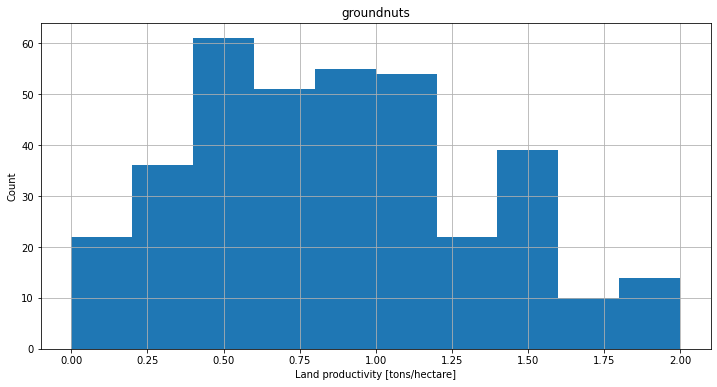

In [6]:
# Histogram of target variable
df.loc[(df[full_target_crop_name] ==1), target_variable].hist(bins=10, figsize=(12,6))
plt.xlabel("Land productivity [tons/hectare]")
plt.ylabel("Count")
plt.title(full_target_crop_name)

<AxesSubplot:>

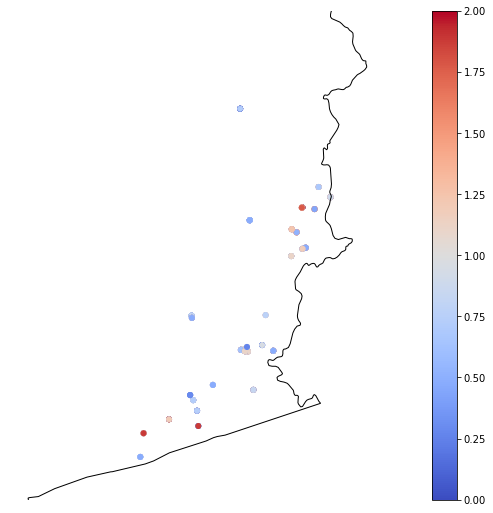

In [7]:
# Scatter plot of locations and productivity
world = gpd.read_file('../../data/geodata/countries.geojson').to_crs('EPSG:4326')
zambia = world[world.ADMIN == 'Zambia']
gdf = gpd.GeoDataFrame(data = df[target_variable],geometry=gpd.points_from_xy(df["gps_lon"], df["gps_lat"]), crs='epsg:4326')

ax = gplt.pointplot(gdf,cmap='coolwarm', hue=target_variable, legend=True,  figsize=(12,9))
gplt.polyplot(zambia, ax=ax, zorder=1, extent=(30,-15,34, -10))

<AxesSubplot:>

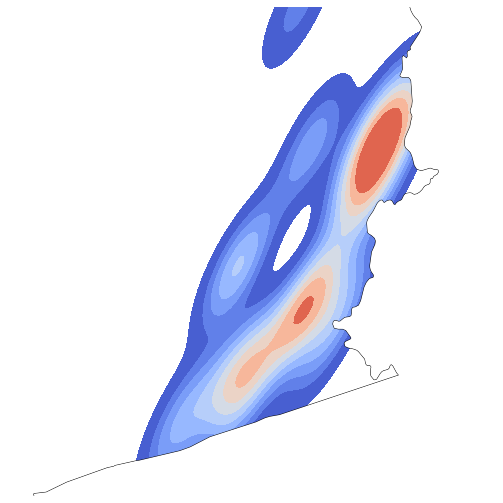

In [8]:
# Plot heatmap of producitivity in form of a KDE-plot
world = gpd.read_file('../../data/geodata/countries.geojson').to_crs('EPSG:4326')
zambia = world[world.ADMIN == 'Zambia']
gdf = gpd.GeoDataFrame(data = df[target_variable],geometry=gpd.points_from_xy(df["gps_lon"], df["gps_lat"]), crs='epsg:4326')

ax = gplt.kdeplot(gdf, clip=zambia.geometry, shade=True, cmap='coolwarm',  figsize=(12,9))
gplt.polyplot(zambia, ax=ax, zorder=1, extent=(30,-15,34, -11))

# More sophisticated approach using kriging

In [9]:
from pykrige.uk import UniversalKriging

gridx = np.arange(30, 34, 0.1)
gridy = np.arange(11, 15,0.1)
xv, yv = np.meshgrid(gridx, gridy)

In [10]:
UK = UniversalKriging(
    df.loc[crop_mask, "gps_lon"].values,
    -df.loc[crop_mask, "gps_lat"].values,
    df.loc[crop_mask, target_variable].values,
    variogram_model="linear"
)

(-14.9, -11.0)

<Figure size 864x648 with 0 Axes>

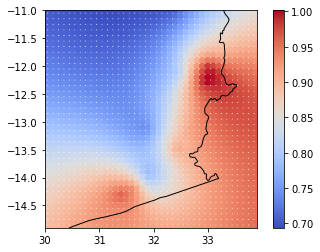

In [11]:
world = gpd.read_file('../../data/geodata/countries.geojson').to_crs('EPSG:4326')
zambia = world[world.ADMIN == 'Zambia']

plt.figure(figsize=(12,9))
z, ss = UK.execute("grid", gridx, gridy)
gdf = gpd.GeoDataFrame(data = {"prod": z.flatten()},geometry=gpd.points_from_xy(xv.flatten(), -yv.flatten()), crs='epsg:4326')
ax = gdf.plot("prod", cmap="coolwarm", legend=True)
zambia.plot(color="none", edgecolor='black', ax=ax)
plt.xlim([30,33.9])
plt.ylim([-14.9,-11])

# More feature preprocessing for modelling

In [12]:
# Drop rows which show more than 50 percent missing values
df = df.drop(columns=df.columns[df.isnull().sum()>0.1*len(df.index)])

In [13]:
# Get remaining feature names
feature_names = df.columns[(df.dtypes == "int64") |(df.dtypes == "float64")]

In [14]:
# Manually remove features which would induce model leakage or would be unknown at later prediction
features_to_remove = ["gps_lat", "gps_lon", "gps_alt", "district", "groundnuts", "soybeans", "land_amount", "date", "village", "survey", "so_vol","so_area", "gr_vol", "gr_area", "plateau_or_valley", 'gr_land_prod', "gr_prod_compare", "so_land_prod", "so_prod_compare", "Unnamed: 0", "so_fungicides_amount"]
feature_names = [feature for feature in feature_names if not feature in features_to_remove ]
feature_names = [feature for feature in feature_names if not non_target_crop in feature[0:2]]

categorical_features = df_raw.columns[(df_raw.dtypes == "int64")]
categorical_features = [feature for feature in categorical_features if not feature in features_to_remove ]
categorical_features = [feature for feature in categorical_features if not non_target_crop in feature[0:2]]

numerical_features = list(set(feature_names)- set(categorical_features))

In [15]:
from sklearn.impute import SimpleImputer # Could also do this with pipeline

# Impute numerical features with mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=1)
df[numerical_features] = imputer.fit_transform(df[numerical_features])

# Impute categorical feature with most frequent value
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[categorical_features] = imputer.fit_transform(df[categorical_features])

In [16]:
# Normalize categorical features
from sklearn.preprocessing import StandardScaler
df[numerical_features] = StandardScaler().fit_transform(df[numerical_features])

# Start modelling

In [17]:
# Try out various models in a quick (& bit dirty) way. Could also do this in a pipeline in the future.
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

#model = RandomForestRegressor(max_depth=5, n_estimators=2000, n_jobs=4)
#model = LinearRegression(normalize=True, n_jobs=4)
#model = ElasticNet(normalize=True, l1_ratio=0.9, alpha=0.1, max_iter=2000)
#model = XGBRegressor(max_depth=10, n_estimators=100, n_jobs=4, learning_rate=0.01, verbosity=1, reg_lambda=0.01, reg_alpha=0)
model = cb.CatBoostRegressor(max_depth=5, n_estimators=1000, thread_count=4, learning_rate=0.1, verbose=1, cat_features=categorical_features)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[feature_names], 
                                                    df[target_variable], 
                                                    test_size=0.3, 
                                                    random_state=40)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0:	learn: 0.4615461	total: 50.5ms	remaining: 50.4s
1:	learn: 0.4567557	total: 54.2ms	remaining: 27.1s
2:	learn: 0.4511176	total: 58.5ms	remaining: 19.4s
3:	learn: 0.4450637	total: 62.8ms	remaining: 15.6s
4:	learn: 0.4405563	total: 66.3ms	remaining: 13.2s
5:	learn: 0.4358329	total: 71.4ms	remaining: 11.8s
6:	learn: 0.4315349	total: 74.9ms	remaining: 10.6s
7:	learn: 0.4285482	total: 78.6ms	remaining: 9.74s
8:	learn: 0.4238521	total: 82.3ms	remaining: 9.06s
9:	learn: 0.4213210	total: 86.5ms	remaining: 8.57s
10:	learn: 0.4172766	total: 90.1ms	remaining: 8.1s
11:	learn: 0.4152206	total: 93.6ms	remaining: 7.71s
12:	learn: 0.4139686	total: 97.7ms	remaining: 7.42s
13:	learn: 0.4108715	total: 102ms	remaining: 7.15s
14:	learn: 0.4080571	total: 105ms	remaining: 6.89s
15:	learn: 0.4057121	total: 108ms	remaining: 6.67s
16:	learn: 0.4025164	total: 112ms	remaining: 6.48s
17:	learn: 0.3993447	total: 116ms	remaining: 6.3s
18:	learn: 0.3959932	total: 119ms	remaining: 6.14s
19:	learn: 0.3934916	total: 12

193:	learn: 0.1651465	total: 626ms	remaining: 2.6s
194:	learn: 0.1648288	total: 629ms	remaining: 2.6s
195:	learn: 0.1646068	total: 632ms	remaining: 2.59s
196:	learn: 0.1636474	total: 634ms	remaining: 2.58s
197:	learn: 0.1618811	total: 637ms	remaining: 2.58s
198:	learn: 0.1617739	total: 640ms	remaining: 2.57s
199:	learn: 0.1611362	total: 643ms	remaining: 2.57s
200:	learn: 0.1599363	total: 646ms	remaining: 2.57s
201:	learn: 0.1597693	total: 649ms	remaining: 2.56s
202:	learn: 0.1596317	total: 653ms	remaining: 2.56s
203:	learn: 0.1584737	total: 658ms	remaining: 2.57s
204:	learn: 0.1573635	total: 662ms	remaining: 2.56s
205:	learn: 0.1572190	total: 665ms	remaining: 2.56s
206:	learn: 0.1566886	total: 668ms	remaining: 2.56s
207:	learn: 0.1564947	total: 672ms	remaining: 2.56s
208:	learn: 0.1560003	total: 676ms	remaining: 2.56s
209:	learn: 0.1549455	total: 679ms	remaining: 2.55s
210:	learn: 0.1542464	total: 681ms	remaining: 2.55s
211:	learn: 0.1540938	total: 684ms	remaining: 2.54s
212:	learn: 0.

397:	learn: 0.0795247	total: 1.2s	remaining: 1.82s
398:	learn: 0.0792128	total: 1.2s	remaining: 1.81s
399:	learn: 0.0791257	total: 1.21s	remaining: 1.81s
400:	learn: 0.0784434	total: 1.21s	remaining: 1.81s
401:	learn: 0.0783363	total: 1.21s	remaining: 1.8s
402:	learn: 0.0780930	total: 1.22s	remaining: 1.8s
403:	learn: 0.0780275	total: 1.22s	remaining: 1.8s
404:	learn: 0.0779929	total: 1.22s	remaining: 1.8s
405:	learn: 0.0776309	total: 1.23s	remaining: 1.79s
406:	learn: 0.0772115	total: 1.23s	remaining: 1.79s
407:	learn: 0.0770875	total: 1.23s	remaining: 1.79s
408:	learn: 0.0767889	total: 1.24s	remaining: 1.79s
409:	learn: 0.0764781	total: 1.24s	remaining: 1.79s
410:	learn: 0.0763170	total: 1.24s	remaining: 1.78s
411:	learn: 0.0759582	total: 1.25s	remaining: 1.78s
412:	learn: 0.0758011	total: 1.25s	remaining: 1.78s
413:	learn: 0.0755640	total: 1.25s	remaining: 1.77s
414:	learn: 0.0754720	total: 1.25s	remaining: 1.77s
415:	learn: 0.0752321	total: 1.26s	remaining: 1.77s
416:	learn: 0.0751

607:	learn: 0.0441599	total: 1.78s	remaining: 1.15s
608:	learn: 0.0439892	total: 1.78s	remaining: 1.14s
609:	learn: 0.0438458	total: 1.78s	remaining: 1.14s
610:	learn: 0.0437304	total: 1.78s	remaining: 1.14s
611:	learn: 0.0437052	total: 1.79s	remaining: 1.13s
612:	learn: 0.0436860	total: 1.79s	remaining: 1.13s
613:	learn: 0.0436340	total: 1.79s	remaining: 1.13s
614:	learn: 0.0434514	total: 1.8s	remaining: 1.13s
615:	learn: 0.0434335	total: 1.8s	remaining: 1.12s
616:	learn: 0.0432957	total: 1.81s	remaining: 1.12s
617:	learn: 0.0432272	total: 1.81s	remaining: 1.12s
618:	learn: 0.0431702	total: 1.81s	remaining: 1.11s
619:	learn: 0.0428113	total: 1.81s	remaining: 1.11s
620:	learn: 0.0427576	total: 1.82s	remaining: 1.11s
621:	learn: 0.0426875	total: 1.82s	remaining: 1.11s
622:	learn: 0.0421541	total: 1.82s	remaining: 1.1s
623:	learn: 0.0420942	total: 1.82s	remaining: 1.1s
624:	learn: 0.0419526	total: 1.83s	remaining: 1.1s
625:	learn: 0.0418927	total: 1.83s	remaining: 1.09s
626:	learn: 0.041

818:	learn: 0.0261224	total: 2.35s	remaining: 519ms
819:	learn: 0.0261067	total: 2.35s	remaining: 517ms
820:	learn: 0.0261021	total: 2.36s	remaining: 514ms
821:	learn: 0.0260947	total: 2.36s	remaining: 511ms
822:	learn: 0.0259999	total: 2.36s	remaining: 508ms
823:	learn: 0.0258919	total: 2.37s	remaining: 505ms
824:	learn: 0.0258085	total: 2.37s	remaining: 503ms
825:	learn: 0.0257308	total: 2.37s	remaining: 500ms
826:	learn: 0.0255777	total: 2.38s	remaining: 497ms
827:	learn: 0.0255013	total: 2.38s	remaining: 495ms
828:	learn: 0.0252585	total: 2.38s	remaining: 492ms
829:	learn: 0.0251219	total: 2.39s	remaining: 489ms
830:	learn: 0.0250697	total: 2.39s	remaining: 486ms
831:	learn: 0.0250172	total: 2.39s	remaining: 483ms
832:	learn: 0.0249529	total: 2.4s	remaining: 480ms
833:	learn: 0.0248511	total: 2.4s	remaining: 477ms
834:	learn: 0.0247930	total: 2.4s	remaining: 474ms
835:	learn: 0.0246815	total: 2.4s	remaining: 472ms
836:	learn: 0.0246235	total: 2.41s	remaining: 469ms
837:	learn: 0.02

RMSE: 0.434
Expl Variance: 0.141
R2 Score: 0.134


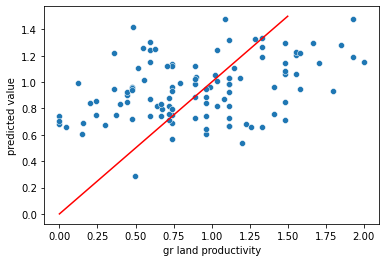

In [19]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
sns.scatterplot(x=y_test, y=predictions)
sns.lineplot(x=[0,1.5], y=[0, 1.5], color="r")
plt.ylabel("predicted value")
plt.xlabel(f"{target_crop} land productivity")

print("RMSE:", np.round(mean_squared_error(y_test, predictions, squared=False), 3))
print("Expl Variance:", np.round(explained_variance_score(y_test, predictions),3))
print("R2 Score:", np.round(r2_score(y_test, predictions),3))

> As we can see here the modelling does not work that well. We only do slightly better than predicting the mean. The reasons are mainly the huge uncertantity & variation in the target variable even at village level which are discussed in depth in the final report.

# Inspect the most important features

In [20]:
try:
    display(pd.DataFrame({"name": feature_names, "importance":model.feature_importances_}).sort_values("importance", ascending=False).head(30).reset_index(drop=True))
except:
    display(pd.DataFrame({"name": feature_names, "importance":model.coef_}).sort_values("importance", ascending=False).head(50))

name  importance
0             gr_children_household_workdays    4.505132
1                                   nr_field    4.449133
2                            train_frequency    4.300468
3                 gr_male_household_workdays    3.441080
4                     production_other_crops    3.420189
5                             livestock_pigs    2.965473
6                               gr_pay_hired    2.832481
7            gr_prod_compare_rainfall_excess    2.279636
8                              gr_male_hired    2.112204
9                 gr_prod_compare_lack_seeds    1.986908
10              gr_female_household_workdays    1.980392
11                                food_worry    1.929127
12                          livestock_cattle    1.833019
13                                 curiosity    1.776391
14                              agroforestry    1.744908
15                        ocd_100-200cm_mean    1.714963
16                                 food_less    1.594743
17                                radio_time    1.563436
18  gr_prod_compare_labor_unavailable_family    1.530753
19                          ocd_30-60cm_mean    1.424115
20                       gr_female_household    1.414660
21                     gr_children_household    1.367932
22                     gr_prod_compare_other    1.307578
23                           clay_0-5cm_mean    1.198969
24                           livestock_ducks    1.178733
25                                       stp    1.131594
26                    nitrogen_60-100cm_mean    1.127012
27                         bdod_30-60cm_mean    1.123553
28                           ocs_0-30cm_mean    1.107596
29                                   stp_avg    1.091109

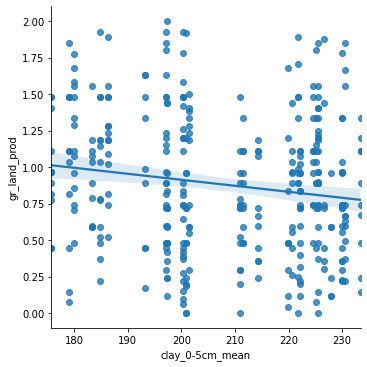

In [21]:
# Visualize a specific feature variable of interest (here shown for clay at surface level)
sns.lmplot(x="clay_0-5cm_mean", y=target_variable, data=df_raw)